# Lab 03: First GAN in PyTorch

In [ ]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/GAN_Course"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
  !pwd

We're running Colab
Colab: mounting Google drive on  /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Colab: making sure  /content/drive/My Drive/Colab Notebooks/GAN_Course  exists.

Colab: Changing directory to  /content/drive/My Drive/Colab Notebooks/GAN_Course
/content/drive/My Drive/Colab Notebooks/GAN_Course
/content/drive/My Drive/Colab Notebooks/GAN_Course


Author Henrik Horst, opencampus.sh

10.11.2022

In this notebook, we're going to create our first generative adversarial network (GAN)! Specifically, we will build and train a GAN that can generate hand-written images of digits (0-9). 

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) 

In [ ]:
# check if CUDA is available
# this is a standard code for checking which device is avaible in saving it as the default device for later use
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

##Again Data first😺

In [ ]:
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    generator=torch.Generator(device=device),
    batch_size=128,
    shuffle=True)


In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision. utils import make_grid
from torch. utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed( θ)
[1] import imageio
import glob
emojis = []
for im_path in glob.glob("/content/drive/MyDrive/GAN Course/emojis/image/Apple/*.png"):
im = imageio.imread(im_path)
#print(im.shape)
emojis. append (im)


##Neural Network -GAN

### Generator
The first step is to build the generator layers. This is not strictly necessary but it keeps our Generator class which we will implement next lightweight.

We will start by creating a function to make a single layer/block for the generator's neural network. Each block should include a [linear transformation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to map to another shape, a [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for stabilization, and finally a non-linear activation function (we use a [ReLU here](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)). 

In [ ]:
def build_generator_layer(input_dim, output_dim):
    '''
    Function for returning a layer of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a ReLU activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.GELU(),
        )

Now we can build the generator class. It will take 3 inputs:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the Generator will build a neural network with 5 layers/blocks (We hard-code that). Beginning with the noise vector, the generator will apply non-linear transformations on it by passing it through the layers until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST). We will need to change the code for the final layer since it is different than the others. The final layer does not need a normalization or activation function, but does need to be scaled with a [sigmoid function](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html). 

Finally, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network.


In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super().__init__()
        # Build the neural network
        self.generator_model = nn.Sequential(
            build_generator_layer(z_dim, hidden_dim), # Layer 1
            build_generator_layer(hidden_dim, hidden_dim * 2), # Layer 2
            build_generator_layer(hidden_dim * 2, hidden_dim * 4), # Layer 3
            build_generator_layer(hidden_dim * 4, hidden_dim * 8), # Layer 4
            nn.Linear(hidden_dim * 8, im_dim), # First part of layer 5 (layer 5 is also the output layer)
            nn.Sigmoid(), # Second part of layer 5 (layer 5 is also the output layer)
            )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        output_vector= self.generator_model(noise)
        return output_vector
    

### Noise
To be able to use our generator, we will need to be able to create noise vectors. The noise vector z has the important role of making sure that the generated images don't all look the same. Despite all our advanced mathematical transformation we implemented in the Generator class above it is still a deterministic function which maps each input vector always to the exact same output vector. Here the output vector is our generated image. So we will generate the input vector randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, you will generate all the noise vectors (this is how we will call our input vectors from now on) at once.

Whenever we create a new tensor using torch.ones, torch.zeros, or torch.randn, we either need to create it on the target device, e.g. `torch.ones(3, 3, device=device)`, or move it onto the target device using `torch.ones(3, 3).to(device)`. We do not need to do this if we're creating a tensor by manipulating another tensor or by using a variation that defaults the device to the input, such as `torch.ones_like`. In general, use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros` where possible.

In [ ]:
def build_noise_input_vetors(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    
    return torch.randn(n_samples, z_dim, device=device)
    

### Discriminator
The second component that we need to construct is the discriminator. As with the generator layers, we will start by creating a function that builds a neural network layer for the discriminator.

*Note: We use leaky ReLUs to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient. You will learn more about this in the following tutorials!* 


In [ ]:
def build_discriminator_layer(input_dim, output_dim):
    '''
    Function for returning a layer of the discriminator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        # nn.LeakyReLU(negative_slope=0.2)
        nn.GELU()
        )

Now you can use these layers to make a discriminator! The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Note that you do not need a sigmoid after the output layer since it is included in the loss function. Finally, to use your discrimator's neural network you are given a forward pass function that takes in an image tensor to be classified.


In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.discriminator_model = nn.Sequential(
            build_discriminator_layer(im_dim, hidden_dim * 4), # Layer 1
            build_discriminator_layer(hidden_dim * 4, hidden_dim * 2), # Layer 2
            build_discriminator_layer(hidden_dim * 2, hidden_dim), # Layer 3
            nn.Linear(hidden_dim,1) # Layer 4 (layer 4 is also the output layer)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.discriminator_model(image)

## Training
Now we can put it all together!
First, we will set your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   lr: the learning rate
  *   device: the device type,  a GPU (which runs CUDA) or a CPU




In [ ]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 30
z_dim = 64 #length of the noise vector
display_step = 500
lr = 0.00001




Now, you can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [ ]:
gen = Generator(z_dim).to(device) # build a Generator Model from the Generator class
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr) # define an Adam optimizer for the Generator
disc = Discriminator().to(device) # build a Discriminator Model from the Discriminator class
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr) # define an Adam optimizer for the Discriminator

Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, you will need to call .detach() on the generator result to ensure that only the discriminator is updated!

Remember that you have already defined a loss function earlier (`criterion`) and you are encouraged to use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros`. If you use `torch.ones` or `torch.zeros`, you'll need to pass `device=device` to them.

In [ ]:
def compute_discriminator_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''

    noise = build_noise_input_vetors(num_images, z_dim, device=device) #  Create noise vectors   
    fake_images = gen(noise) # generate a batch (num_images) of fake images.
    disc_fake_pred = disc(fake_images.detach()) # Get the discriminator's prediction of the fake images
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) # calculate the loss - the labels are all zero (i.e. fake) so we can just build them in the loss function
    disc_real_pred = disc(real) # Get the discriminator's prediction of the real images
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred)) # calculate the loss - the labels are all one (i.e. real) so we can just build them in the loss function
    disc_loss = (disc_fake_loss + disc_real_loss) / 2 # Calculate the discriminator's loss by averaging the real and fake loss and set it to disc_loss.
  
    return disc_loss

In [ ]:
def compute_generator_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    
    noise = build_noise_input_vetors(num_images, z_dim, device=device) # Create noise vectors 
    fake_images = gen(noise) # generate a batch of fake images
    disc_fake_pred = disc(fake_images) # Get the discriminator's prediction of the fake images
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) # Calculate the generator's loss - the generator wants the discriminator to think that its fake images are real i.e. the labels have to be one

    return gen_loss

Finally, you can put everything together! For each epoch, you will process the entire dataset in batches. For every batch, we will need to update the discriminator and generator using their loss. 

It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN and something we will see more of in later tutorials.

Play around with the architecture if you want to see how different architectural choices can lead to better or worse GANs. For example, consider changing the size of the hidden dimension, or making the networks shallower or deeper by changing the number of layers.


In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 0.4298054814934731, discriminator loss: 0.8014990381002423


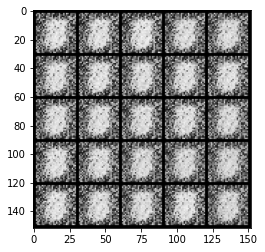

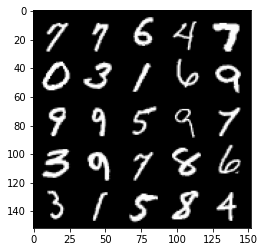

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 0.39678125798702246, discriminator loss: 0.6180230698585512


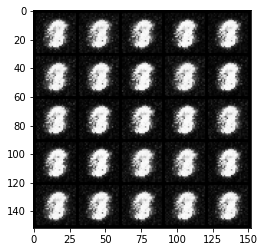

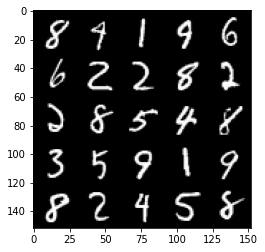

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 0.3904739471673963, discriminator loss: 0.5985166413784027


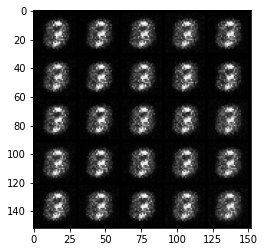

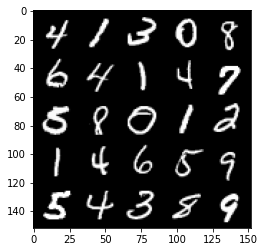

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 0.32166169309616105, discriminator loss: 0.742803041100502


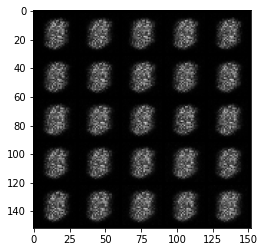

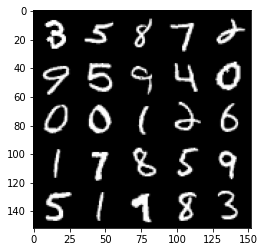

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 0.32857504987716657, discriminator loss: 0.745408771395682


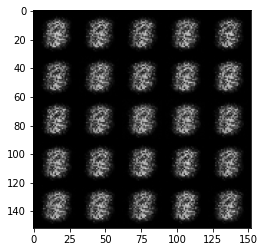

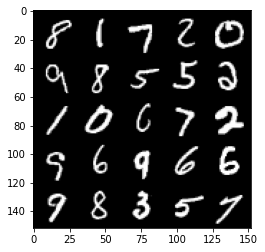

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 0.3402885705828668, discriminator loss: 0.7098370624780652


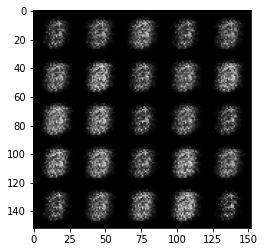

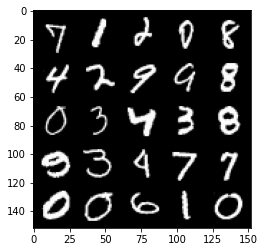

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 0.3186837552785872, discriminator loss: 0.7663244262933723


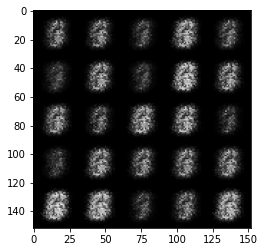

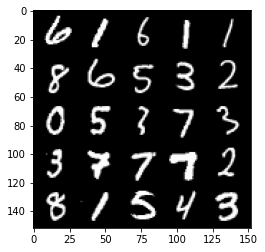

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 0.32544452065229396, discriminator loss: 0.7336729675531389


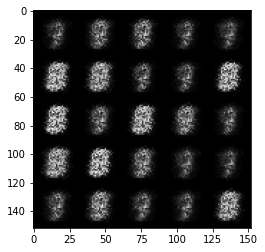

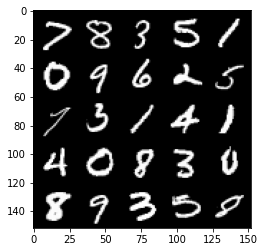

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 0.35002333152294185, discriminator loss: 0.6782510093450549


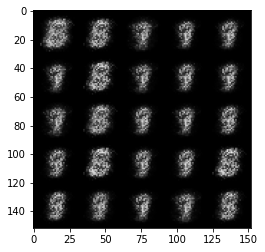

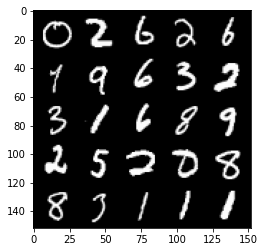

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 0.3570317641496657, discriminator loss: 0.673164243221283


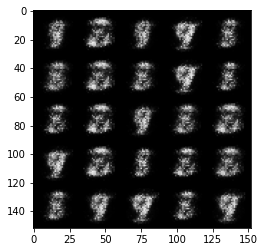

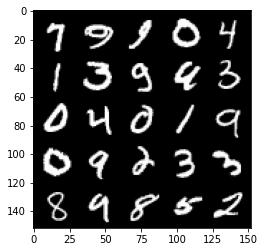

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 0.3442203414440156, discriminator loss: 0.7066594586372378


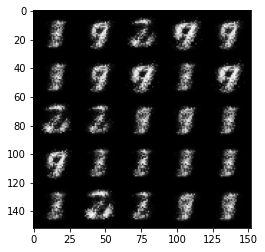

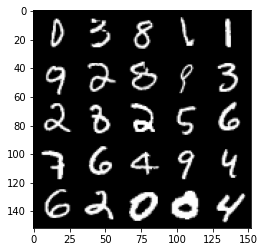

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 0.3376742205023767, discriminator loss: 0.7134813957214359


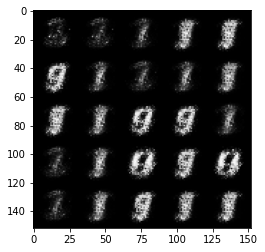

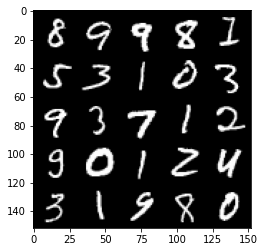

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 0.34286935091018644, discriminator loss: 0.6937746454477306


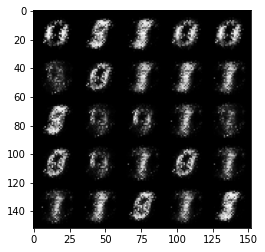

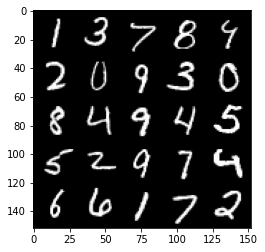

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 0.3451570143103602, discriminator loss: 0.708920157670975


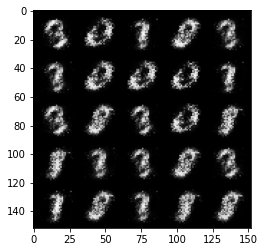

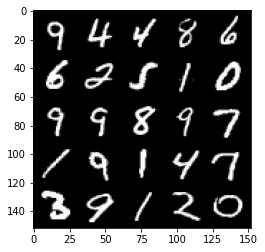

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 0.33648694986104927, discriminator loss: 0.730386123776435


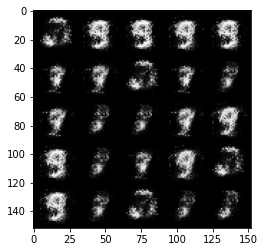

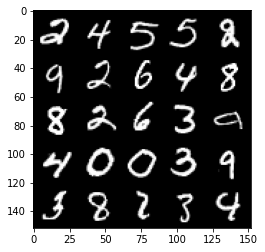

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 0.3314880183339117, discriminator loss: 0.7382789071798324


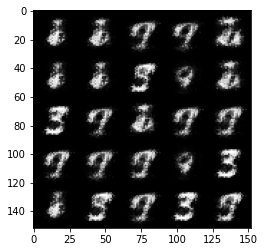

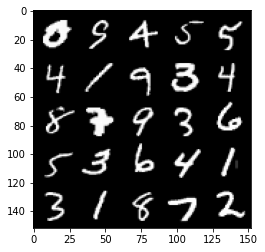

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 0.3209980732202531, discriminator loss: 0.7643206198215488


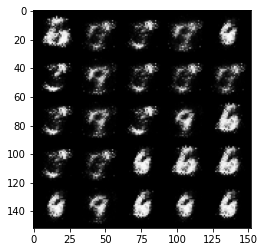

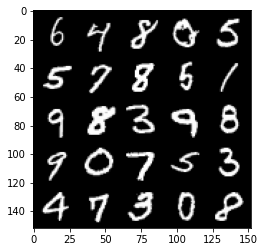

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 0.3343643874526022, discriminator loss: 0.7380995231866837


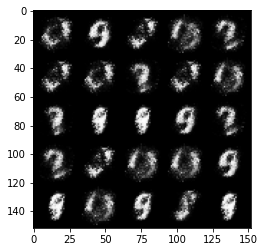

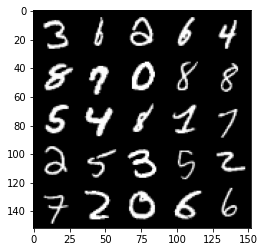

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 0.34281195348501187, discriminator loss: 0.7163999227285389


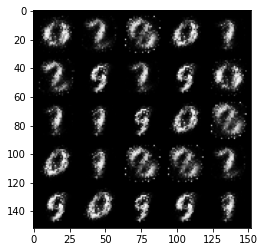

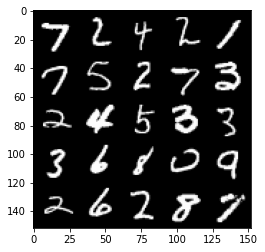

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 0.3331309059262275, discriminator loss: 0.7197018287181851


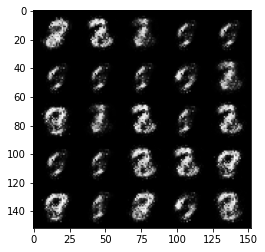

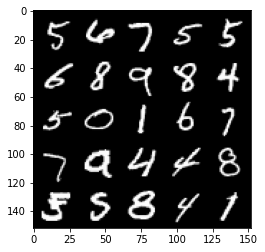

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 0.32423448050022124, discriminator loss: 0.7626686280965812


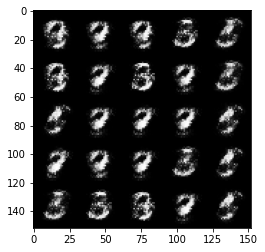

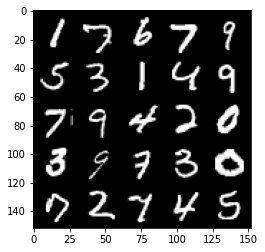

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 0.3340951709151267, discriminator loss: 0.735487319350242


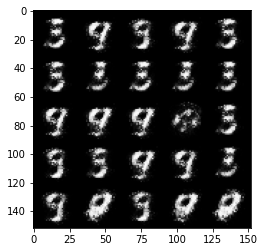

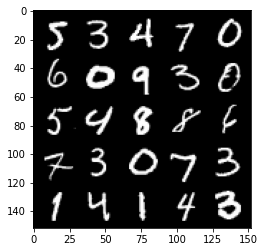

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 0.33372323626279854, discriminator loss: 0.7283343349695208


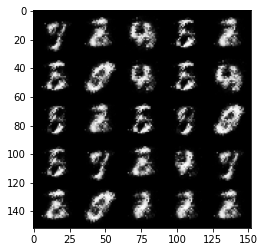

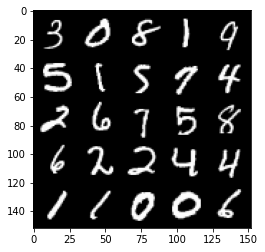

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 0.33537702536582953, discriminator loss: 0.721093254327774


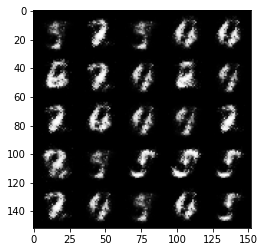

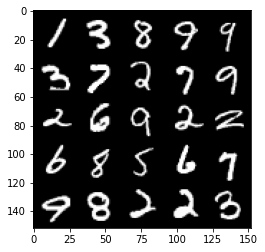

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 0.3425433894991875, discriminator loss: 0.7009295369386671


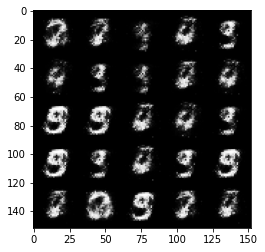

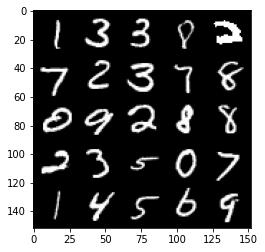

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 0.3423487723469736, discriminator loss: 0.6975337252616879


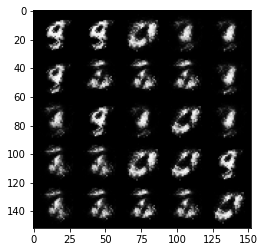

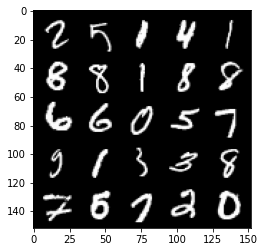

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 0.3424726337790493, discriminator loss: 0.7188699645996096


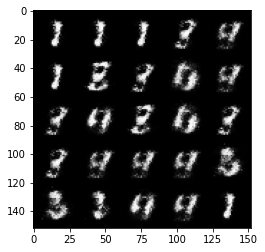

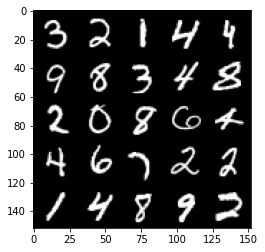

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 0.3415800895690916, discriminator loss: 0.712687132000923


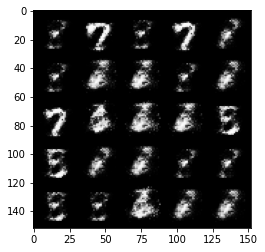

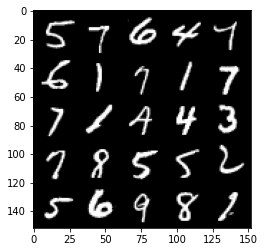

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
error = False

##Training starts here!!!
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        
        # Calculate discriminator loss
        disc_loss = compute_discriminator_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # Zero out the gradients for the next pass
        disc_opt.zero_grad()


        ### Update generator ###
        
        gen_loss = compute_generator_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        gen_opt.zero_grad()
        
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = build_noise_input_vetors(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
